# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *
import pickle
import hls4ml


2022-06-10 14:03:55.773552: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-10 14:03:55.778684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 14:03:55.778700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [6]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
boosted_model =  tf.keras.models.load_model('../../pb_file')

boosted_model.summary()

2022-06-08 10:46:10.189787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 10:46:10.189824: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 10:46:10.189865: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-08 10:46:10.190432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [9]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 100 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 3

def units(j): return (j+8)
units_range = 1

In [10]:
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 7

In [14]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5"      #optimized model = model_decay<class 'keras.regularizers.L2'>=1e-07_v0

#path of the qconverted models
def qmodels_path(i,k): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}.h5"

#path of the qconverted models
def qhist_path(i,k): return f"tests/qhist/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}.pkl"

#path of the qtrained models
def qtrained_models_path(i, v, k): return f"tests/qmodels/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"

def qtrained_hist_path(i, v, k): return f"tests/qhist/qmodels_scatch_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

## Data creation 

In [12]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()


shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


# 2. Quantizing it 

## Quantization training 

In [23]:
print(qtrained_models_path(0,1,0))
print(qkeras.utils.load_qmodel(qtrained_models_path(0,1,0)).layers[0].recurrent_quantizer)
print(qkeras.utils.load_qmodel(qtrained_models_path(0,1,0)).layers[0].kernel_quantizer)

tests/qmodels/qmodels_scatch_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>_rest=8_v1.h5
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 2, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 8, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}


14063/14063 [==============================] - 41s 3ms/step - loss: 4.4602e-05 - val_loss: 1.6839e-05 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_6 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_6 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 41s 3ms/step - loss: 1.6846e-05 - val_loss: 1.4994e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 39s 3ms/step - loss: 1.5962e-05 - val_loss: 1.6272e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 41s 3ms/step - loss: 1.550

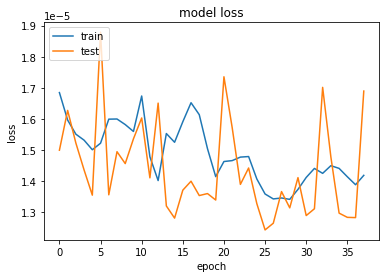

14063/14063 [==============================] - 43s 3ms/step - loss: 3.3794e-05 - val_loss: 1.8243e-05 - lr: 0.0010
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_8 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_8 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 37s 3ms/step - loss: 1.8147e-05 - val_loss: 1.8985e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 38s 3ms/step - loss: 1.7512e-05 - val_loss: 1.6616e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 41s 3ms/step - loss: 1.614

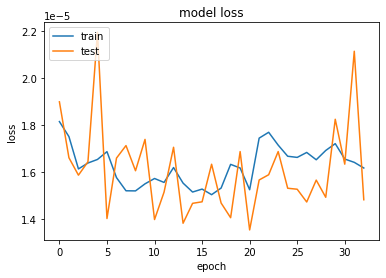

14063/14063 [==============================] - 41s 3ms/step - loss: 4.5652e-05 - val_loss: 2.7055e-05 - lr: 0.0010
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_10 (QSimpleRNN  (None, 8)                80        
 )                                                               
                                                                 
 q_dense_10 (QDense)         (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 42s 3ms/step - loss: 2.0011e-05 - val_loss: 1.5452e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 40s 3ms/step - loss: 1.7381e-05 - val_loss: 1.5076e-05 - lr: 0.0010
Epoch 3/200
14063/

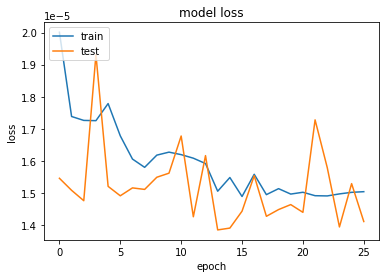

14063/14063 [==============================] - 43s 3ms/step - loss: 5.9736e-05 - val_loss: 2.3546e-05 - lr: 0.0010
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_11 (QSimpleRNN  (None, 8)                80        
 )                                                               
                                                                 
 q_dense_11 (QDense)         (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 39s 3ms/step - loss: 1.9281e-05 - val_loss: 1.8705e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 40s 3ms/step - loss: 1.8719e-05 - val_loss: 1.8626e-05 - lr: 0.0010
Epoch 3/200
14063/

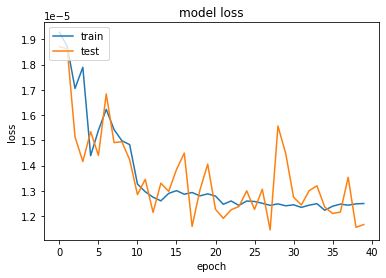

14063/14063 [==============================] - 43s 3ms/step - loss: 3.7347e-05 - val_loss: 1.7243e-05 - lr: 0.0010
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_15 (QSimpleRNN  (None, 8)                80        
 )                                                               
                                                                 
 q_dense_15 (QDense)         (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 38s 3ms/step - loss: 1.7000e-05 - val_loss: 1.8468e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 39s 3ms/step - loss: 1.4947e-05 - val_loss: 1.3836e-05 - lr: 0.0010
Epoch 3/200
14063/

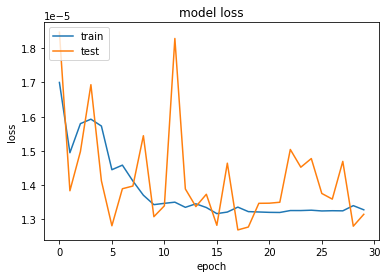

14063/14063 [==============================] - 39s 3ms/step - loss: 3.1021e-05 - val_loss: 1.5367e-05 - lr: 0.0010
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_17 (QSimpleRNN  (None, 8)                80        
 )                                                               
                                                                 
 q_dense_17 (QDense)         (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 40s 3ms/step - loss: 1.5301e-05 - val_loss: 2.0443e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 37s 3ms/step - loss: 1.4366e-05 - val_loss: 1.5253e-05 - lr: 0.0010
Epoch 3/200
14063/

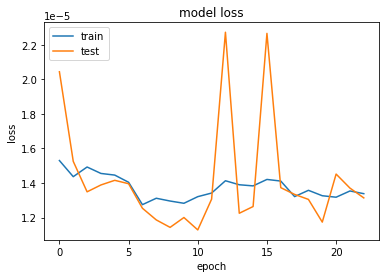

14063/14063 [==============================] - 43s 3ms/step - loss: 2.9155e-05 - val_loss: 1.4428e-05 - lr: 0.0010
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_18 (QSimpleRNN  (None, 8)                80        
 )                                                               
                                                                 
 q_dense_18 (QDense)         (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 39s 3ms/step - loss: 1.5344e-05 - val_loss: 1.4351e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 41s 3ms/step - loss: 1.4830e-05 - val_loss: 1.5246e-05 - lr: 0.0010
Epoch 3/200
14063/

KeyboardInterrupt: 

In [18]:
def quantized_model (bits, units_parameter,k):  
    rest_bit_width =  {'bits':rest_array[k], 'integer': integer, 'symmetric': 0, 'alpha':1}    

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        qr_model = Sequential()
        qr_model.add(QSimpleRNN(units_parameter,
                            input_dim= 1,
                            activation='relu',
                            kernel_quantizer=quantized_bits(**rest_bit_width),
                            recurrent_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**rest_bit_width)    
                            )) 
        qr_model.add(QDense(output, 
                            activation='relu',
                            kernel_quantizer=quantized_bits(**rest_bit_width),
                            bias_quantizer=quantized_bits(**rest_bit_width) ))
        qr_model.compile(loss="mse", optimizer=Adam(lr))
        history = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = 1, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])

        val_loss = history.history['val_loss'][0]

        
    qr_model.summary()

    hist = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return qr_model, hist

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for k in range(rest_units_range):            
            for v in range(versions_range):
                if (os.path.exists(qtrained_models_path(i,v,k))==False):
                    units_parameter = 8
                    qmodel = quantized_model(bits_parameter, units_parameter,k)
                    qmodel[0].save(qtrained_models_path(i,v,k))
                    with open(qtrained_hist_path(i,v,k), 'wb') as file_pi:
                        pickle.dump(qmodel[1].history, file_pi)     
                    qmodels.append(qmodel[0])
                else : print(f'{qtrained_models_path(i,v,k)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        